Bu ödevinizde verilen ratings.csv dosyasını kullanacaksınız. Bu dosyada kullanıcıların farklı ürünler için verdikleri puanlar vardır. En yüksek puan 10'dur.

Ödevinizde pandas, numpy kütüphanelerini kullanabilirsiniz. Ayrıca grafik oluşturmak için herhangi bir görselleştirme kütüphanesi kullanabilirsiniz. Bunlar dışında herhangi bir kütüphane kullanamazsınız.

Tüm yakınlık hesaplamaları için kosinus benzerliğini kullanınız.

**Sorularda belirtilmeyen bir parametre vs. var ise, o kısım sizin dizayn kararınıza bırakılmıştır demektir. Bu durumlarda aldığınız kararı belirtiniz.**

**Soru 1 [5 puan]** İlgili veri kümesinin “ratings.csv” verisinde satır sayısının mod 10’u sıfır olan satırlar test için gerisi eğitim için kullanılacaktır. Yani, 10. 20., 30., … satırlar test için kullanılacaktır. Eğitim ve test kümelerini belirleyiniz. Satırları saymaya 0'dan başlayınız.

In [1]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('Ratings.csv')
ratings = ratings.drop_duplicates(subset=['User-ID', 'ISBN'], keep='first')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
test = ratings.iloc[9::10, :]
train = ratings.drop(ratings.index[9::10])

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [5]:
print("Before dropping 0 values: ", train.shape)
train = train[train['Book-Rating'] != 0]
print("After dropping 0 values: ", train.shape)

Before dropping 0 values:  (943605, 4)
After dropping 0 values:  (357457, 4)


**Soru 2 [20 puan]** Item bazlı “Collaborative filtering” yöntemini kullanarak en yakın 5 komşuyu göz önünde alarak test kümesinin ilk beş değeri için yapılan tahmin değerlerini ve gerçek değeri gösteriniz. 

In [6]:
import numpy as np

def calculate_similarity(main_vec, other_vec): # pearson correlation coefficient
    fill_value = np.nan
    filled_main = [fill_value if np.isnan(x) else x for x in main_vec]
    main_vec = np.array(filled_main)

    filled_other = [fill_value if np.isnan(x) else x for x in other_vec]
    other_vec = np.array(filled_other)
    
    main_vec_indices = np.where(~np.isnan(main_vec))[0]
    other_vec_indices = np.where(~np.isnan(other_vec))[0]

    common_indices = np.intersect1d(main_vec_indices, other_vec_indices)

    if common_indices.size == 0:
        return 0
    
    main_mean = np.nanmean(main_vec)
    other_mean = np.nanmean(other_vec)

    main_vec_common = main_vec[common_indices]
    other_vec_common = other_vec[common_indices]

    main_vec_common = main_vec_common - main_mean
    other_vec_common = other_vec_common - other_mean

    dot_product = np.dot(main_vec_common, other_vec_common)
    norm_main = np.linalg.norm(main_vec_common)
    norm_other = np.linalg.norm(other_vec_common)

    if dot_product == 0:
        intersection = np.minimum(main_vec[common_indices], other_vec[common_indices])
        union = np.maximum(main_vec[common_indices], other_vec[common_indices])
        return np.sum(intersection) / np.sum(union)
       
    similarity = dot_product / (norm_main * norm_other)
    
    return similarity

In [8]:
def Item_item_filter(data, item_id, user_id, k=10, print_output=False):

    if item_id not in data['ISBN'].unique():
        if print_output:
            print("Item not found in train data.")
        return None 
    
    if user_id not in data['User-ID'].unique():
        if print_output:
            print("User not found in train data.")
        return None

    filtered_data = data[data['User-ID'] == user_id]
    item_ids_with_user = filtered_data['ISBN'].tolist()
    item_ids_with_user.append(item_id)

    temp_data = data[data['ISBN'].isin(item_ids_with_user)]

    utility_matrix = temp_data.groupby(['ISBN','User-ID'])['Book-Rating'].max().unstack(fill_value=np.nan)

    utility_matrix.index.name = None
    utility_matrix.columns.name = None
    sparse_dtype = pd.SparseDtype(float, fill_value=np.nan)
    utility_matrix = utility_matrix.astype(sparse_dtype)
    utility_matrix = utility_matrix.loc[:, ~utility_matrix.columns.duplicated()]

    main_vec = utility_matrix.loc[item_id].values

    utility_matrix.drop(item_id, axis=0, inplace=True)
    utility_matrix['similarity'] = utility_matrix.apply(lambda x: calculate_similarity(main_vec, x.values), axis=1)

    most_similar_items = utility_matrix.sort_values(by='similarity', ascending=False).index[:k]

    similarities = utility_matrix.loc[most_similar_items]['similarity']
    ratings = utility_matrix.loc[most_similar_items][user_id]

    if similarities.sum() == 0:
        rec_score = data[data['ISBN'] == item_id]['Book-Rating'].mean()
        return round(rec_score,2)
    
    rec_score = round(np.dot(ratings, similarities) / similarities.sum(),2)
    
    return rec_score

In [9]:
a = [0 , 2, 5 , np.nan, 7, 9, np.nan, 10, 12, 15, np.nan]
b = [np.nan, 3, 6, 8, np.nan, 10, 12, np.nan, 14, 16, 18]

calculate_similarity(a, b)

0.8976077309958997

In [10]:
print("Train shape :", train.shape)
print("User-ID unique :", train['User-ID'].nunique())
print("ISBN unique :", train['ISBN'].nunique())

Train shape : (357457, 4)
User-ID unique : 66455
ISBN unique : 162558


In [11]:
test.head(5)

,User-ID,ISBN,Book-Rating,Price
0,276745,342310538,10,69
1,276747,671537458,9,31
2,276755,451166892,5,13
3,276762,3404611306,0,72
4,276762,3453213025,3,10


**Soru 3 [20 puan]** Kullanıcı bazlı “Collaborative filtering” yöntemini kullanarak en yakın 5 komşuyu göz önünde alarak test kümesinin ilk beş değeri için yapılan tahmin değerlerini ve gerçek değeri gösteriniz.

In [12]:
def User_user_filter(data, user_id, item_id, k=10, print_output=False):

    utility_matrix = None
    if item_id not in data['ISBN'].unique():
        if print_output:
            print("Item not found in train data.")
        return None 
    
    if user_id not in data['User-ID'].unique():
        if print_output:
            print("User not found in train data.")
        return None

    filtered_data = data[data['ISBN'] == item_id]
    user_ids_with_isbn = filtered_data['User-ID'].tolist()
    user_ids_with_isbn.append(user_id)

    temp_data = data[data['User-ID'].isin(user_ids_with_isbn)]

    utility_matrix = temp_data.groupby(['User-ID', 'ISBN'])['Book-Rating'].max().unstack(fill_value=np.nan)

    utility_matrix.index.name = None
    utility_matrix.columns.name = None
    sparse_dtype = pd.SparseDtype(float, fill_value=np.nan)
    utility_matrix = utility_matrix.astype(sparse_dtype)
    utility_matrix = utility_matrix.loc[:, ~utility_matrix.columns.duplicated()]

    main_vec = utility_matrix.loc[user_id].values

    utility_matrix.drop(user_id, axis=0, inplace=True)
    utility_matrix['similarity'] = utility_matrix.apply(lambda x: calculate_similarity(main_vec, x.values), axis=1)

    most_similar_users = utility_matrix.sort_values(by='similarity', ascending=False).index[:k]

    similarities = utility_matrix.loc[most_similar_users]['similarity']
    ratings = utility_matrix.loc[most_similar_users][item_id]

    
    if similarities.sum() == 0:
        rec_score = data[data['ISBN'] == item_id]['Book-Rating'].mean()
        return round(rec_score,2)
    
    

    rec_score = round(np.dot(ratings, similarities) / similarities.sum(),2)
    
    return rec_score

**Item ya da User'ın train setinde olmadığı durumları çıkarttım. Sadece sonuç hesaplanabilen durumları kullandım. Bunları da manuel belirledim. proper_idx listesine atadım.**

In [13]:
proper_idx = [1, 13, 18, 21, 28, 36]

In [14]:
for idx in proper_idx:
    print("idx :", idx)
    user_id = test.iloc[idx]['User-ID']
    isbn = test.iloc[idx]['ISBN']
    print('Gerçek Değer :' ,test.iloc[idx]['Book-Rating'])
    print('Tahmin Değeri :' , User_user_filter(train,  user_id, isbn, k= 5))
    print('-----------------------------------')

idx : 1
Gerçek Değer : 9


Tahmin Değeri : 8.0
-----------------------------------
idx : 13
Gerçek Değer : 0
Tahmin Değeri : 8.0
-----------------------------------
idx : 18
Gerçek Değer : 7
Tahmin Değeri : 7.36
-----------------------------------
idx : 21
Gerçek Değer : 0
Tahmin Değeri : 9.0
-----------------------------------
idx : 28
Gerçek Değer : 10
Tahmin Değeri : 7.5
-----------------------------------
idx : 36
Gerçek Değer : 7
Tahmin Değeri : 6.0
-----------------------------------


**Soru 4 [15 puan]**  Item bazlı “Collaborative filtering” yöntemini kullanarak en yakın komşu sayısı 1, 3, 5, ve 7 olduğunda test kümesi üzerinde RMSE değerlerini hesaplayınız ve sonuçlarınızı bir figür ya da tablo gibi açıkca anlaşılacak bir şekilde gösteriniz.

In [15]:
print("Before :",test.shape)
"""
0 olanların gerçek değerleri olmadığı için çıkardım.
Trainde olmayan kullanıcıları ve kitapları çıkardım.
Yoksa RMSE hesaplamak çok uzun sürüyor.
Aşağıdaki 4-5. soruları test_ üzerinden yaptım.
"""
test = test[test['Book-Rating'] != 0]
test = test[test['User-ID'].isin(train['User-ID'])]
test = test[test['ISBN'].isin(train['ISBN'])]
test.drop_duplicates(subset=['User-ID', 'ISBN'], keep='first', inplace=True)
print("After :",test.shape)

test_idx = []
shift = test.shape[0]//10
for i in range(0, test.shape[0], shift):
    test_idx.append(i)

test_ = test.iloc[test_idx, :]

Before : (104845, 4)
After : (23910, 4)


In [16]:
RMSE_values = []
test_predicts = []
for k in range(1,8,2):
    predict = []
    for idx in test_.index:
        predict.append(Item_item_filter(train, test_.loc[idx, 'ISBN'], test_.loc[idx, 'User-ID'], k, print_output=False))
    test_predicts.append(predict)
    test_['predict'] = predict
    RMSE = np.sqrt(np.mean((test_['predict'] - test_['Book-Rating'])**2))
    RMSE_values.append(RMSE)
    print('k = ', k, 'için RMSE değeri: ', RMSE)

k =  1 için RMSE değeri:  2.572158626523644
k =  3 için RMSE değeri:  2.5435762225653864
k =  5 için RMSE değeri:  2.5575378785073744
k =  7 için RMSE değeri:  2.59085314134167


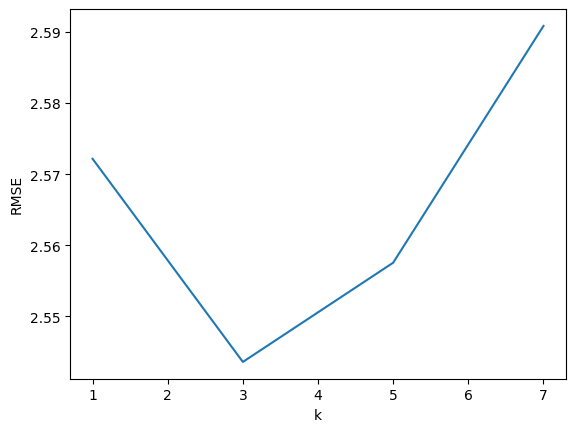

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1,8,2), RMSE_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

**Soru 5 [15 puan]**  Kullanıcı bazlı “Collaborative filtering” yöntemini kullanarak en yakın komşu sayısı 1, 3, 5, ve 7 olduğunda test kümesi üzerinde RMSE değerlerini hesaplayınız ve sonuçlarınızı bir figür ya da tablo gibi açıkca anlaşılacak bir şekilde gösteriniz.

In [18]:
RMSE_values = []
test_predicts = []
for k in range(1,8,2):
    predict = []
    for idx in test_.index:
        predict.append(User_user_filter(train, test_.loc[idx, 'User-ID'], test_.loc[idx, 'ISBN'], k, print_output=False))
    test_predicts.append(predict)
    test_['predict'] = predict
    RMSE = np.sqrt(np.mean((test_['predict'] - test_['Book-Rating'])**2))
    RMSE_values.append(RMSE)
    print('k = ', k, 'için RMSE değeri: ', RMSE)

k =  1 için RMSE değeri:  2.046939178383178
k =  3 için RMSE değeri:  1.9691978062145001
k =  5 için RMSE değeri:  1.9522602285556092
k =  7 için RMSE değeri:  1.9628346848372125


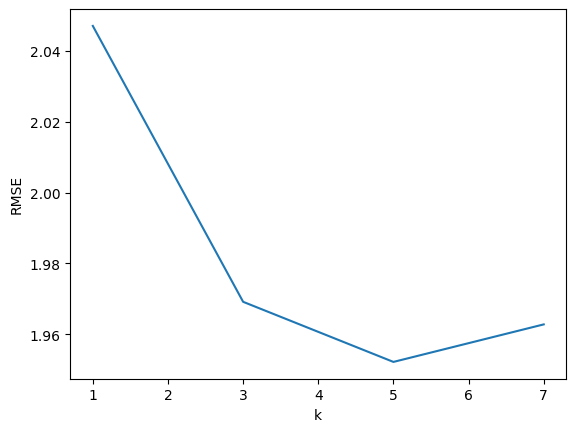

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1,8,2), RMSE_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

**Soru 6 [25 puan]**  Kullanıcıya döndüğünüz ürünlerden ilk 5'inde 9 veya 10 puan olan ürünleri satın alacak. 

In [36]:
random_users = np.random.choice(test['User-ID'].unique(), size=50, replace=False)
random_test = test[test['User-ID'].isin(random_users)]
random_test.shape

(144, 4)

**a) Bir kullanıcı maksimum 5 ürün alacaksa, test kümesinde maksimum toplam satış kaç olabilir?** 

Tüm test verisinde yapmak uzun sürdüğü için yukardaki gibi sample alıp o şekilde yaptım.

In [37]:
random_test['Predict_by_Item_item'] = random_test.apply(lambda row: Item_item_filter(train, row['ISBN'], row['User-ID'], k = 5), axis=1)

In [38]:
random_test['Predict_by_User_user'] = random_test.apply(lambda row: User_user_filter(train, row['User-ID'], row['ISBN'], k = 5), axis=1)

In [40]:
print("We are predicting total buyable items for {} users with {} books reaed by them.".format(len(random_test["User-ID"].unique()), random_test.shape[0]))

We are predicting total buyable items for 50 users with 144 books reaed by them.


In [41]:
total_buyable_item = 0
for user in random_test['User-ID'].unique():
    user_df = random_test[random_test['User-ID'] == user]
    item_count = 0
    for item in user_df['ISBN'].unique():
        if user_df[user_df['ISBN'] == item]['Predict_by_Item_item'].values[0] >= 9:
            item_count += 1
    total_buyable_item += min(item_count, 5)

print('Total Buyable Item for {} users by Item-item Collaborative filter: {}'.format(len(random_test['User-ID'].unique()), total_buyable_item))

Total Buyable Item for 50 users by Item-item Collaborative filter: 37


In [42]:
total_buyable_item = 0
for user in random_test['User-ID'].unique():
    user_df = random_test[random_test['User-ID'] == user]
    item_count = 0
    for item in user_df['ISBN'].unique():
        if user_df[user_df['ISBN'] == item]['Predict_by_User_user'].values[0] >= 9:
            item_count += 1
    total_buyable_item += min(item_count, 5)

print('Total Buyable Item for {} users by User-user Collaborative filter: {}'.format(len(random_test['User-ID'].unique()), total_buyable_item))

Total Buyable Item for 50 users by User-user Collaborative filter: 35


**b) Önceki sorularda geliştirdiğiniz kullanıcı bazlı “Collaborative filtering” ve Item bazlı “Collaborative filtering” yöntemlerine göre firmanın kazanacağı parayı hesaplayınız. “Collaborative filtering” yöntemlerinde bakılacak en yakın komşu sayısı 5'tir.**

In [43]:
total_income = 0
for user in random_test['User-ID'].unique():
    user_df = random_test[random_test['User-ID'] == user]
    prices = []
    for item in user_df['ISBN'].unique():
        if user_df[user_df['ISBN'] == item]['Predict_by_Item_item'].values[0] >= 9:
            prices.append(user_df[user_df['ISBN'] == item]['Price'].values[0])

    total_income += sum(prices[:5]) if len(prices) >= 5 else sum(prices)


print('Total Income for {} users by Item-item Collaborative filter: {}'.format(len(random_test['User-ID'].unique()), total_income))

Total Income for 50 users by Item-item Collaborative filter: 2061


In [44]:
total_income = 0
for user in random_test['User-ID'].unique():
    user_df = random_test[random_test['User-ID'] == user]
    prices = []
    for item in user_df['ISBN'].unique():
        if user_df[user_df['ISBN'] == item]['Predict_by_User_user'].values[0] >= 9:
            prices.append(user_df[user_df['ISBN'] == item]['Price'].values[0])

    total_income += sum(prices[:5]) if len(prices) >= 5 else sum(prices)


print('Total Income for {} users by User-user Collaborative filter: {}'.format(len(random_test['User-ID'].unique()), total_income))

Total Income for 50 users by User-user Collaborative filter: 2022


**c) Firmanın kazandığı parayı da arttıracak şekilde Item bazlı “Collaborative filtering” yöntemini geliştiriniz. Önerdiğiniz yöntem ile ne kadar kazanç olacağını hesaplayınız.**

In [45]:
def book_recommendation(data, user_id):
    books_read_by_user = data[data["User-ID"] == user_id]['ISBN'].unique()
    
    important_users = []
    
    for user in data['User-ID'].unique():
        books_by_user = data[data["User-ID"] == user]['ISBN'].unique()
        intersection = np.intersect1d(books_read_by_user, books_by_user)
        if len(intersection) == len(books_by_user): # user'a önerebileceğimiz başka kitap yok
            continue

        if len(intersection) >= 1:
            if len(intersection) == 1: 
                if data[(data["User-ID"] == user) & (data["ISBN"] == intersection[0])]['Book-Rating'].values[0] < 9: # user'ın okuduğu kitap 9'dan küçük puan almışsa
                    continue

            important_users.append(user)

    if important_users == []:
        return None

    important_users.append(user_id)

    check_data = data[data['User-ID'].isin(important_users)]

    not_readed_books = check_data[~check_data['ISBN'].isin(books_read_by_user)]['ISBN'].unique()
    not_readed_books = check_data[check_data['ISBN'].isin(not_readed_books)].sort_values('Price', ascending = False)['ISBN'].unique() # önce en pahalı kitapları önermeye çalışıyorum

    recommended_books = []

    for book in not_readed_books:
        pred = Item_item_filter(check_data, book, user_id, k = 3)
        if pred >= 9: # user 9 üzeri puan vereceği kitapları öneriyoruz
            recommended_books.append(book)
            if len(recommended_books) == 5: #en fazla 5 kitap alıyor.
                break

    return recommended_books

In [46]:
random_users = np.random.choice(test['User-ID'], size = 50 , replace = False)

In [47]:
total_income = 0

for user in random_users:
    recommendations = book_recommendation(train, user)
    if recommendations is not None:
        for book in recommendations:
            book_price = train[train['ISBN'] == book]['Price'].mean()
            total_income += book_price

print("Total income by {} users is {}$".format(len(random_users), round(total_income)))

Total income by 50 users is 5335$
